## ConvBench: A Comprehensive Convolution Performance Assessment Benchmark

---

ConvBench provides an end-to-end platform for convolution algorithms evaluation. It leverage well-defined names for all processing steps of a convolution algorithms alongside a timing assessment API, creating a fair environment to compare different convolution algorithms in more than 9000 2D convolution layers extracted from the Hugging face TIMM's deep learning model collection.

This Jupyter notebook aggregates the process of assessing the convolution performance with ConvBench in only one place. 

Quick overview:

In order to use ConvBench benchmark, proceed through the following steps.

1. Convolution Filtering:
    - Specify the subset of convolution operation to assess the algorithm given an easy-to-use filtering system.
2. Operation Implementation:
    - Implement your own convolution algorithm in C++.
3. Execution:
    - Set up the execution parameters and hit the **execute** button to see the magic happen.
4. Summarization:
    - Algorithm understanding with detailed timing results and insightful plots.

For more information and proper Operation Implementation, see the detailed description of [README](README.md).

In [16]:
## imports
import os
import time
import shutil
import pickle
import warnings
import subprocess
import pandas as pd
from tqdm import tqdm
import ipywidgets as widgets
import matplotlib.pyplot as plt

---

### Convolution Filtering

Complete the provided filtering form with the desired convolution features. This will extract a subset containing all the matching convolution operations for subsequent assessment.

In [17]:
%%bash
if [[ -f "tmp/conv.pkl" ]]; then
    echo "Convolution Operation Set file exist!"
else
    echo "Convolution Operation Set file do not exist!"
    echo "Creating one ..."

    python utils/timm_convolution_extraction.py
    mv conv.pkl tmp/conv.pkl
fi

Convolution Operation Set file exist!


In [18]:
basic_filtering={
                    "elementwise": widgets.Checkbox(description="Elementwise Convolutions",      value=False, layout=widgets.Layout(display="flex", justify_content="flex-start", width="600px")),
                    "normal": widgets.Checkbox(description="Normal Convolutions (kernel > 1x1)", value=True, layout=widgets.Layout(display="flex", justify_content="flex-start", width="600px")), 
                    "grouped": widgets.Checkbox(description="Grouped Convolutions",              value=False, layout=widgets.Layout(display="flex", justify_content="flex-start", width="600px")),
                    "dilated": widgets.Checkbox(description="Dilated Convolutions",              value=False, layout=widgets.Layout(display="flex", justify_content="flex-start", width="600px")), 
                    "square_filters_only": widgets.Checkbox(description="Only Square Filters",   value=True, layout=widgets.Layout(display="flex", justify_content="flex-start", width="600px")), 
                    "square_images_only": widgets.Checkbox(description="Only Square Images",     value=True, layout=widgets.Layout(display="flex", justify_content="flex-start", width="600px"))
                 }
tab_basic = widgets.VBox([*basic_filtering.values()])

layout = widgets.Layout(width="50pt")
advanced_filtering ={"enable?":     widgets.Button(description="Enable Advanced Filtering ?", button_style="success", layout=widgets.Layout(display="flex", justify_content="center", width="450px")),
                     "C_enabled":   widgets.Checkbox(description="Filter by Channels (C)", disabled=True),
                     "C_rel":       widgets.Dropdown( options=[('<'), ('=='), ('>')], layout=layout, disabled=True),
                     "C":           widgets.IntText(layout=layout, disabled=True),
                     "Hi_enabled":  widgets.Checkbox(description="Filter by Image Height (Hi)", disabled=True),
                     "Hi_rel":      widgets.Dropdown( options=[('<'), ('=='), ('>')], layout=layout, disabled=True),
                     "Hi":          widgets.IntText(layout=layout, disabled=True),
                     "Wi_enabled":  widgets.Checkbox(description="Filter by Image Width (Wi)", disabled=True),
                     "Wi_rel":      widgets.Dropdown( options=[('<'), ('=='), ('>')], layout=layout, disabled=True),
                     "Wi":          widgets.IntText(layout=layout, disabled=True),
                     "D_enabled":   widgets.Checkbox(description="Filter by Dimensions (D)", disabled=True),
                     "D_rel":       widgets.Dropdown( options=[('<'), ('=='), ('>')], layout=layout, disabled=True),
                     "D":           widgets.IntText(layout=layout, disabled=True),
                     "Ho_enabled":  widgets.Checkbox(description="Filter by Output Height (Ho)", disabled=True),
                     "Ho_rel":      widgets.Dropdown( options=[('<'), ('=='), ('>')], layout=layout, disabled=True),
                     "Ho":          widgets.IntText(layout=layout, disabled=True),
                     "Wo_enabled":  widgets.Checkbox(description="Filter by Output Width (Wo)", disabled=True),
                     "Wo_rel":      widgets.Dropdown( options=[('<'), ('=='), ('>')], layout=layout, disabled=True),
                     "Wo":          widgets.IntText(layout=layout, disabled=True),
                     "Hk_enabled":  widgets.Checkbox(description="Filter by Kernel Height (Hk)", disabled=True),
                     "Hk_rel":      widgets.Dropdown( options=[('<'), ('=='), ('>')], layout=layout, disabled=True),
                     "Hk":          widgets.IntText(layout=layout, disabled=True),
                     "Wk_enabled":  widgets.Checkbox(description="Filter by Kernel Width (Wk)", disabled=True),
                     "Wk_rel":      widgets.Dropdown( options=[('<'), ('=='), ('>')], layout=layout, disabled=True),
                     "Wk":          widgets.IntText(layout=layout, disabled=True),
                     "Hs_enabled":  widgets.Checkbox(description="Filter by Horizontal Stride (Hs)", disabled=True),
                     "Hs_rel":      widgets.Dropdown( options=[('<'), ('=='), ('>')], layout=layout, disabled=True),
                     "Hs":          widgets.IntText(layout=layout, disabled=True),
                     "Ws_enabled":  widgets.Checkbox(description="Filter by Vertical Stride (Ws)", disabled=True),
                     "Ws_rel":      widgets.Dropdown( options=[('<'), ('=='), ('>')], layout=layout, disabled=True),
                     "Ws":          widgets.IntText(layout=layout, disabled=True),
                     "Hpt_enabled": widgets.Checkbox(description="Filter by Top Padding (Hpt)", disabled=True),
                     "Hpt_rel":     widgets.Dropdown( options=[('<'), ('=='), ('>')], layout=layout, disabled=True),
                     "Hpt":         widgets.IntText(layout=layout, disabled=True),
                     "Hpb_enabled": widgets.Checkbox(description="Filter by Bottom Padding (Hpb)", disabled=True),
                     "Hpb_rel":     widgets.Dropdown( options=[('<'), ('=='), ('>')], layout=layout, disabled=True),
                     "Hpb":         widgets.IntText(layout=layout, disabled=True),
                     "Wpl_enabled": widgets.Checkbox(description="Filter by Lef Padding (Wpl)", disabled=True),
                     "Wpl_rel":     widgets.Dropdown( options=[('<'), ('=='), ('>')], layout=layout, disabled=True),
                     "Wpl":         widgets.IntText(layout=layout, disabled=True),
                     "Wpr_enabled": widgets.Checkbox(description="Filter by Right Padding (Wpr)", disabled=True),
                     "Wpr_rel":     widgets.Dropdown( options=[('<'), ('=='), ('>')], layout=layout, disabled=True),
                     "Wpr":         widgets.IntText(layout=layout, disabled=True),
                     "Bias":        widgets.Checkbox(description="Do it have bias ?", disabled=True)
                     }
middle_widgets = list(advanced_filtering.values())

def disable_handler(b):
    if b.button_style == "danger":
        b.button_style = "success"
        b.description = "Enable Advanced Filtering ?"

        for w in middle_widgets[1::3]:
            w.value = False
            w.disabled = True

        for w in middle_widgets[2::3]:
            w.value = "__lt__"
            w.disabled = True

        for w in middle_widgets[3::3]:
            w.value = 0
            w.disabled = True

    else:
        b.button_style = "danger"
        b.description = "Disable Advanced Filtering ?"

        for w in middle_widgets[1:]:
            w.disabled = not w.disabled

advanced_filtering["enable?"].on_click(disable_handler)


header = widgets.HBox([widgets.Label("Parameter", layout=widgets.Layout(display="flex", justify_content="center", width="300px")), 
                       widgets.Label("Relation",  layout=widgets.Layout(display="flex", justify_content="center", width="50pt")), 
                       widgets.Label("Value",     layout=widgets.Layout(display="flex", justify_content="center", width="50pt"))])

middle_hboxes = [widgets.HBox([middle_widgets[i], middle_widgets[i+1], middle_widgets[i+2]]) for i in range(1, len(middle_widgets)-1, 3)]
middle_vboxes = widgets.VBox(middle_hboxes)
# middle_items = widgets.GridBox(list(advanced_filtering.values())[1:], layout=widgets.Layout(grid_template_columns="repeat(3)"))
tab_advanced = widgets.VBox([advanced_filtering["enable?"], header, middle_vboxes, advanced_filtering["Bias"]])

tab = widgets.Tab([tab_basic, tab_advanced])
tab.set_title(0, "Basic Filtering")
tab.set_title(1, "Advanced Filtering")

display(tab)

In [19]:
#construction of expression string
expression = []

## basic filterings are hardcoded.
if basic_filtering["elementwise"].value:
    expression.append(f"(df['Hk'] == 1) & (df['Wk'] == 1)")

if basic_filtering["normal"].value:
    expression.append(f"(df['Hk'] != 1) & (df['Wk'] != 1)")

if basic_filtering["grouped"].value:
    expression.append(f"(df['G'] != 1)")
else:
    expression.append(f"(df['G'] == 1)")

if basic_filtering["dilated"].value:
    expression.append(f"(df['Hd'] != 1) & (df['Wd'] != 1)")
else:
    expression.append(f"(df['Hd'] == 1) & (df['Wd'] == 1)")

if basic_filtering["square_filters_only"].value:
    expression.append(f"(df['Hk'] == df['Wk'])")

if basic_filtering["square_images_only"].value:
    expression.append(f"(df['Hi'] == df['Wi'])")


## advanced filtering. Look whether the key are selected and add to the expression string.
if advanced_filtering["enable?"].button_style == "danger":

    keys = list(advanced_filtering.keys())
    for i in range(1, len(middle_widgets)-1, 3):
        if middle_widgets[i].value == True:
            expression.append(f"(df[{keys[i+2]}] {middle_widgets[i+1].value} {middle_widgets[i+2].value})")

## construct the final filtering string
expression = "df.loc[" + " & ".join(expression) + ", :].reset_index()"
print(f'Final Filtering Expression: "{expression}"')

Final Filtering Expression: "df.loc[(df['Hk'] != 1) & (df['Wk'] != 1) & (df['G'] == 1) & (df['Hd'] == 1) & (df['Wd'] == 1) & (df['Hk'] == df['Wk']) & (df['Hi'] == df['Wi']), :].reset_index()"


In [20]:
# load pkl to pandas dataframe

## split pickle key
def split_key(key):
    inp, out, kernel, bias = key.split('_')

    inp = list(map(int, inp.split(',')))
    out = list(map(int, out.split(',')))

    kernel = kernel.split('-')
    kernel_size = list(map(int, kernel[0].split(',')))
    padding = list(map(int, kernel[1].split(',')))
    stride = list(map(int, kernel[2].split(',')))
    dilation = list(map(int, kernel[3].split(',')))
    groups = int(kernel[4])
    transposed = bool(1 if kernel[5] == 'True' else 0)

    bias = bool(key[3])
    
    return [key, *inp, *out, *kernel_size, *padding, *stride, *dilation, groups, transposed, out[1] if bias else 0]

## load file
with open('tmp/conv.pkl', 'rb') as handle:
    convs = pickle.load(handle)

## parse pickle dictionary
conv_info = ['key', 'Ni', 'Ci', 'Hi', 'Wi', 'No', 'Do', 'Ho', 'Wo', 'Hk', 'Wk', 'Hpt', 'Hpb', 'Wpl', 'Wpr', 'Hs', 'Ws', 'Hd', 'Wd', 'G', 'T', 'B', 'model', 'model attr']
table =[]
for key in convs.keys():
    path = convs[key]
    models = [x.partition('.')[0] for x in path]
    model_attr = [x.partition('.')[2] for x in path]
    table.append([*split_key(key), models, model_attr])

## create pandas dataframe
df = pd.DataFrame(table, columns=conv_info)
df = df.drop(columns=['T'])
df['FLOPS'] = 2 * df['Ho'] * df['Wo'] * df['Do'] * df['Ci'] * df['Hk'] * df['Wk']

## filter pandas dataframe
filtered_df = eval(expression) 

## Save df to csv
filtered_df.loc[:, 'Ni':'B'].to_csv('tmp/auto_filtered_convset.csv', index_label='ID')

## show a dataframe preview
print(f"{filtered_df.shape[0]} of {df.shape[0]} convolution operation were selected!")
filtered_df.head()

1156 of 9011 convolution operation were selected!


,index,key,Ni,Ci,Hi,Wi,No,Do,Ho,Wo,...,Wpr,Hs,Ws,Hd,Wd,G,B,model,model attr,FLOPS
0,0,"1,3,256,256_1,24,128,128_3,3-1,1,1,1-2,2-1,1-1...",1,3,256,256,1,24,128,128,...,1,2,2,1,1,1,24,"[bat_resnext26ts, botnet26t_256, botnet50ts_25...","[stem.conv1.conv, stem.conv1.conv, stem.conv1....",21233664
1,1,"1,24,128,128_1,32,128,128_3,3-1,1,1,1-1,1-1,1-...",1,24,128,128,1,32,128,128,...,1,1,1,1,1,1,32,"[bat_resnext26ts, botnet26t_256, botnet50ts_25...","[stem.conv2.conv, stem.conv2.conv, stem.conv2....",226492416
2,2,"1,32,128,128_1,64,128,128_3,3-1,1,1,1-1,1-1,1-...",1,32,128,128,1,64,128,128,...,1,1,1,1,1,1,64,"[bat_resnext26ts, botnet26t_256, botnet50ts_25...","[stem.conv3.conv, stem.conv3.conv, stem.conv3....",603979776
3,43,"1,3,224,224_1,768,14,14_16,16-0,0,0,0-16,16-1,...",1,3,224,224,1,768,14,14,...,0,16,16,1,1,1,768,"[beit_base_patch16_224, beitv2_base_patch16_22...","[patch_embed.proj, patch_embed.proj, patch_emb...",231211008
4,44,"1,3,384,384_1,768,24,24_16,16-0,0,0,0-16,16-1,...",1,3,384,384,1,768,24,24,...,0,16,16,1,1,1,768,"[beit_base_patch16_384, cait_m36_384, deit3_ba...","[patch_embed.proj, patch_embed.proj, patch_emb...",679477248


---

###  Operation Implementation

Implement your own convolution operation in the following cells (C++) respecting the ConvBench class interface and, preferably, using the Timing class defined methods. Otherwise the final Summarization step will need to be adapted to your needs.

Use the next code cells to implement your algorithms. In the end, all of them will be collapsed into one C++ file, compiled and, finally, executed.

> ⚠️ Please, be aware of the Timing class and place their methods in the correct places of your implementation.

> ⚠️ System-wide configurations (Cache sizes and Latencies) can be set in the Execution Session. Note that at this point this information are ready and can be used through specific variable names, such as: L1_latency, L1_alpha, L1_size, L2_latency, L2_beta, L2_size, L3_latency, L3_gamma, L3_size, CACHE_block_size, and MEM_latency

In [21]:
%%writefile tmp/INCLUDES.tmp

/*
*   Add needed libraries to be included in the cpp source code
*/

#include <cblas.h>

Overwriting tmp/INCLUDES.tmp


In [22]:
%%writefile tmp/CONVOLUTION.tmp

/*
*   Implement your convolution operaion here! (MANDATORY)
*/

    inline int is_a_ge_zero_and_a_lt_b(int a, int b) {
        return (unsigned)a < (unsigned)b;
    }

    void initialize_buffer(float *buffer, float *bias, int M, int size) {
        for (int i = 0; i < M; i++) {
            for (int j = 0; j < size; j++) {
                buffer[i * size + j] = bias[i];
            }
        }
    }

    // caffe im2col algorithm implementation
    void im2col_cpu(const float *data_im, const int channels, const int height,
                    const int width, const int kernel_h, const int kernel_w,
                    const int pad_h, const int pad_w, const int stride_h,
                    const int stride_w, const int dilation_h, const int dilation_w,
                    float *data_col) {
        const int output_h =
            (height + 2 * pad_h - (dilation_h * (kernel_h - 1) + 1)) / stride_h + 1;

        const int output_w =
            (width + 2 * pad_w - (dilation_w * (kernel_w - 1) + 1)) / stride_w + 1;

        const int channel_size = height * width;
        for (int channel = channels; channel--; data_im += channel_size) {
            for (int kernel_row = 0; kernel_row < kernel_h; kernel_row++) {
                for (int kernel_col = 0; kernel_col < kernel_w; kernel_col++) {
                    int input_row = -pad_h + kernel_row * dilation_h;
                    for (int output_rows = output_h; output_rows; output_rows--) {
                        if (!is_a_ge_zero_and_a_lt_b(input_row, height)) {
                            for (int output_cols = output_w; output_cols; output_cols--) {
                                *(data_col++) = 0;
                            }
                        } 
                        else {
                            int input_col = -pad_w + kernel_col * dilation_w;
                            for (int output_col = output_w; output_col; output_col--) {
                                if (is_a_ge_zero_and_a_lt_b(input_col, width)) {
                                    *(data_col++) = data_im[input_row * width + input_col];
                                } else {
                                    *(data_col++) = 0;
                                }
                                input_col += stride_w;
                            }
                        }
                        input_row += stride_h;
                    }
                }
            }
        }
    }


void convolution(std::vector<T> &inputs,   shape_t &input_shape,
                 std::vector<T> &outputs,  shape_t &output_shape,
                 std::vector<T> &kernels,  shape_t &kernel_shape,  shape_t &strides,   shape_t &pads,  shape_t &dilation,  dim_t &groups,
                 std::vector<T> &bias,     shape_t &bias_shape) override {

    dim_t N       = input_shape[0];
    dim_t C       = input_shape[1];
    dim_t H       = input_shape[2];
    dim_t W       = input_shape[3];

    dim_t M       = kernel_shape[0];
    dim_t kH      = kernel_shape[2];
    dim_t kW      = kernel_shape[3];

    dim_t H_out   = output_shape[2];
    dim_t W_out   = output_shape[3];

    // calculating size of buffers
    int windows_per_image = H_out * W_out;
    int kernel_size = C * kH * kW;
    int output_size = M * windows_per_image;
    int patch_matrix_size = windows_per_image * kernel_size;

    // allocating patch matrix (if needed)
    std::vector<T> patch_matrix_vec;
    T *patch_matrix;
    bool pointwise = (kH == 1 && kW == 1 && strides[0] == 1 && strides[1] == 1);
    if (!pointwise) {
        patch_matrix_vec.resize(patch_matrix_size);
        patch_matrix = patch_matrix_vec.data();
    }

    unsigned long long int input_size = C * H * W;
    T *input = inputs.data();
    T *output = outputs.data();
    double beta = 0.0;
    for (int n = 0; n < N; n++) {

        TIME(this->total_conv_start())
        // 1. set bias
        if (bias_shape[0] != 0) {
            initialize_buffer(output, bias.data(), M, windows_per_image);
            beta = 1.0;
        } else {
            beta = 0.0;
        }

        //  2. im2row
        if (pointwise) {
            patch_matrix = input;
        } else {
            TIME(this->conv_packing_start())
            im2col_cpu(input, C, H, W, kH, kW, pads[0], pads[1], strides[0], strides[1], 1, 1, patch_matrix);
            TIME(this->conv_packing_update())
        }

        // 3. GEMM of kernel x transpose patch matrix
        TIME(this->conv_microkernel_start())
        cblas_sgemm(CblasRowMajor, CblasNoTrans, CblasNoTrans, M, windows_per_image,
                kernel_size, 1.0, kernels.data(), kernel_size, patch_matrix,
                windows_per_image, beta, output, windows_per_image);
        TIME(this->conv_microkernel_update())

        input += input_size;
        output += output_size;
        TIME(this->total_conv_update())
    }
}

Overwriting tmp/CONVOLUTION.tmp


In [23]:
%%writefile -a tmp/CONVOLUTION.tmp

    /*
    *   Implement your baseline convolution operaion here! (OPTIONAL)
    */

    inline int getXYZW(shape_t &dims, dim_t x, dim_t y, dim_t z, dim_t w){
        return (x * dims[1] * dims[2] * dims[3]) + (y * dims[2] * dims[3]) + (z * dims[3]) + w;
    }

    void convolution_baseline(std::vector<T> &inputs,   shape_t &input_shape,
                              std::vector<T> &outputs,  shape_t &output_shape,
                              std::vector<T> &kernels,  shape_t &kernel_shape, shape_t &strides, shape_t &pads, shape_t &dilation, dim_t &groups,
                              std::vector<T> &bias,     shape_t &bias_shape) override {

        // external loop: iterate over samples.
        int ix, iy;
        T acc;
        for (int s = 0; s < input_shape[0]; s++){

            TIME(this->total_conv_start())
        
            // for each output element:
            for (int ox = 0; ox < output_shape[2]; ox++){
                for (int oy = 0; oy < output_shape[3]; oy++){
                    for (int d = 0; d < kernel_shape[0]; d++){

                        TIME(this->conv_microkernel_start())
                        // depthwise acc -> initialized with bias
                        acc = bias[d];
                        // for each kernel element
                        for (int fx = 0; fx < kernel_shape[2]; fx++){
                            for (int fy = 0; fy < kernel_shape[3]; fy++){
                                for (int c = 0; c < kernel_shape[1]; c++){
                                    // calculate input coordinates
                                    ix = ox * strides[0] - pads[0] + fx;
                                    iy = oy * strides[1] - pads[2] + fy;

                                    if (ix >= 0 and ix < input_shape[2] and (iy >= 0 and iy < input_shape[3]))
                                        acc += inputs[getXYZW(input_shape, s, c, ix, iy)] * kernels[getXYZW(kernel_shape, d, c, fx, fy)];
                                }
                            }
                        }
                        outputs[getXYZW(output_shape, s, d, ox, oy)] = acc;
                        TIME(this->conv_microkernel_update())
                    }
                }
            }

            TIME(this->total_conv_update())
        }
    }

Appending to tmp/CONVOLUTION.tmp


---

### Execution

Fill out the following form with the desired experimental settings and trigger the Execute button. This will begin the compilation procedure and, also, the experiment running -- All select convolution subset will be executed by the given algorithm implementation.

In [24]:
layout_lab = widgets.Layout(display="flex", justify_content="center", width="300px")
layout_form = widgets.Layout(display="flex", justify_content="center", width="200px")

cache = widgets.HBox([widgets.Label("Description", layout=layout_lab), widgets.Label("Cache Size (B)", layout=layout_form), widgets.Label("Cache Latency (Cicles)", layout=layout_form), widgets.Label("Cache available portion", layout=layout_form)])
l1_size    = widgets.IntText(layout=layout_form, value=393216)
l1_latency = widgets.IntText(layout=layout_form, value=2)
l1_const   = widgets.FloatText(layout=layout_form, value=0.9)
l1 = widgets.HBox([widgets.Label("L1 Cache", layout=layout_lab), l1_size, l1_latency, l1_const])
l2_size    = widgets.IntText(layout=layout_form, value=4194304)
l2_latency = widgets.IntText(layout=layout_form, value=10)
l2_const   = widgets.FloatText(layout=layout_form, value=0.9)
l2 = widgets.HBox([widgets.Label("L2 Cache", layout=layout_lab), l2_size, l2_latency, l2_const])
l3_size    = widgets.IntText(layout=layout_form, value=16777216)
l3_latency = widgets.IntText(layout=layout_form, value=30)
l3_const   = widgets.FloatText(layout=layout_form, value=0.9)
l3 = widgets.HBox([widgets.Label("L3 Cache", layout=layout_lab), l3_size, l3_latency, l3_const])
cache_block = widgets.IntText(layout=widgets.Layout(display="flex", justify_content="center", width="608px"), value=64)
mem      = widgets.IntText(layout=widgets.Layout(display="flex", justify_content="center", width="608px"), value=300)

runs     = widgets.IntText(disabled=True, layout=widgets.Layout(display="flex", justify_content="center", width="608px"), value=1)
batch    = widgets.IntText(disabled=True, layout=widgets.Layout(display="flex", justify_content="center", width="608px"), value=1)
flags    = widgets.Text(value="-O3 -m64 -march=skylake-avx512 -ftree-vectorize -finline-functions -lopenblas")
timing   = widgets.Checkbox(description="Timing Assessment", value=True)
datatype = widgets.Dropdown(options=['float', 'double', 'long double'], value='float')
logging  = widgets.Checkbox(description="Logging")
proced   = widgets.ToggleButtons(options=["Correctness", "Direct Convolution", "Baseline Convolution", "Speedup Assessment"], layout=widgets.Layout(display="flex", justify_content="center", width="610px"), value="Correctness")
d_gen    = widgets.ToggleButtons(options=["Random", "Constant", "Same Dist", "Load"], layout=widgets.Layout(display="flex", justify_content="center", width="610px"), value="Random", disabled=True)
exec_b   = widgets.Button(description="Execute", button_style="danger", layout=widgets.Layout(display="flex", justify_content="center", width="912px"))

def write_ctor():
    with open("tmp/CONSTRUCTOR.tmp", "w") as ctor_handle:
        ctor =   "\tConvolution(std::string filename) : ConvBench<T>::ConvBench(filename) {\n" + \
                f"\t\tL1_latency = {l1_latency.value};\n" + \
                f"\t\tL1_alpha = {l1_const.value};\n" + \
                f"\t\tL1_size = {l1_size.value} * L1_alpha;\n" + \
                f"\t\tL2_latency = {l2_latency.value};\n" + \
                f"\t\tL2_beta = {l2_const.value};\n" + \
                f"\t\tL2_size = {l2_size.value} * L2_beta;\n" + \
                f"\t\tL3_latency = {l3_latency.value};\n" + \
                f"\t\tL3_gamma = {l3_const.value};\n" + \
                f"\t\tL3_size = {l3_size.value} * L3_gamma;\n" + \
                f"\t\tCACHE_block_size = {cache_block.value};\n" + \
                f"\t\tMEM_latency = {mem.value};\n" + \
                 "\t}"

        ctor_handle.write(ctor)

def write_defs():
    with open("tmp/DEFINES.tmp", "w") as defs_handle:
        defs = f"#define TYPE {datatype.value}\n"
        defs_handle.write(defs)

exec_cp1 = None
exec_cp2 = None
def execution(b):
    b.button_style = "info"
    b.disabled = True

    #write related files
    write_defs()
    write_ctor()

    #run_compiler
    cmd = [os.getenv("$CXX", default=shutil.which("clang++")), "-I./include/", "-L./bin/", "tmp/convolution.cpp", "-o", "tmp/convbench_exec", *flags.value.split(" "), "-lpystring", "-lfmt"]
    if timing.value == True:
        cmd.append("-DTIMING=1")
    if logging.value == True:
        cmd.append("-DCERR_LOG=1")

    comp_cp = subprocess.run(cmd, capture_output=True)
    if comp_cp.returncode != 0: 
        raise RuntimeError(f"Compile step with errors ({' '.join(cmd)}). The following message was returned:\nstdout:\n{comp_cp.stdout.decode('utf-8')}\nstderr:\n{comp_cp.stderr.decode('utf-8')}")

    #execute_bin
    os.environ["LD_LIBRARY_PATH"] = f"{os.getcwd()}/bin"
    assessment = proced.value.split(" ")[0].lower()
    
    if assessment == "speedup":
        exec_cp1 = subprocess.run(["./tmp/convbench_exec", "tmp/auto_filtered_convset.csv", d_gen.value.lower(), "direct"], capture_output=True)
        exec_cp2 = subprocess.run(["./tmp/convbench_exec", "tmp/auto_filtered_convset.csv", d_gen.value.lower(), "baseline"], capture_output=True)
        if exec_cp1.returncode != 0 or exec_cp2.returncode != 0: 
            raise RuntimeError(f"Exec step with errors.\nstdout (p1):{exec_cp1.stdout}\nstderr (p1):{exec_cp1.stderr}\nstdout (p2):{exec_cp2.stdout}\nstderr (p2):{exec_cp2.stderr}")
        with open(f"tmp/timing_direct.csv", "w") as handle: handle.write(exec_cp1.stdout.decode("utf-8"))
        with open(f"tmp/timing_baseline.csv", "w") as handle: handle.write(exec_cp2.stdout.decode("utf-8"))

    else:
        exec_cp1 = subprocess.run(["./tmp/convbench_exec", "tmp/auto_filtered_convset.csv", d_gen.value.lower(), assessment], capture_output=True)
        if exec_cp1.returncode != 0: 
            raise RuntimeError(f"Exec step with errors. The following message was returned:\nstdout:{exec_cp1.stdout}\nstderr:{exec_cp1.stderr}")
        if timing.value and assessment != correctness:
            with open(f"tmp/timing_{assessment}.csv", "w") as handle: handle.write(exec_cp1.stdout.decode("utf-8"))
        else:
            print(exec_cp1.stdout.decode("utf-8"))

    b.button_style = "success"
    b.disabled = False

exec_b.on_click(execution)
display(widgets.VBox([
                        cache, 
                        l1,
                        l2, 
                        l3, 
                        widgets.HBox([widgets.Label("Cache Block Size", layout=widgets.Layout(display="flex", justify_content="center", width="300px")), cache_block]),
                        widgets.HBox([widgets.Label("Memory latency", layout=widgets.Layout(display="flex", justify_content="center", width="300px")), mem]),
                        widgets.HBox(layout=widgets.Layout(display="flex", justify_content="center", height="40px")), 
                        widgets.HBox([widgets.Label("Number of Runs", layout=widgets.Layout(display="flex", justify_content="center", width="300px")), runs]), 
                        widgets.HBox([widgets.Label("Number of Samples per Batch", layout=widgets.Layout(display="flex", justify_content="center", width="300px")), batch]), 
                        widgets.HBox([widgets.Label("Compiler FLAGS", layout=widgets.Layout(display="flex", justify_content="center", width="300px")), flags, timing]), 
                        widgets.HBox([widgets.Label("Data type:", layout=widgets.Layout(display="flex", justify_content="center", width="300px")), datatype, logging]),
                        widgets.HBox([widgets.Label("Assessment procediment:", layout=widgets.Layout(display="flex", justify_content="center", width="300px")), proced]),
                        widgets.HBox([widgets.Label("Data Generation Strategy:", layout=widgets.Layout(display="flex", justify_content="center", width="300px")), d_gen]),
                        exec_b
                      ]))

---

### Result Summarization

Detailed experimental timing measurements, comprehensive table summaries, and informative plots.

In [10]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

tdf = pd.DataFrame()
if   (proced.value == "Direct Convolution" and os.path.isfile("timing_direct.csv")):
    direct = pd.read_csv("timing_direct.csv", header=0, index_col=False)
    tdf = direct
elif (proced.value == "Baseline Convolution" and os.path.isfile("timing_baseline.csv")):
    baseline = pd.read_csv("timing_baseline.csv", header=0, index_col=False)
    tdf = baseline
elif (proced.value == "Speedup Assessment" and os.path.isfile("timing_direct.csv") and os.path.isfile("timing_baseline.csv")):
    direct = pd.read_csv("timing_direct.csv", header=0, index_col=False)
    baseline = pd.read_csv("timing_baseline.csv", header=0, index_col=False)
else:
    warnings.warn('"Correctness" Assessment procediment do not return any timing assessment.')

tdf

""


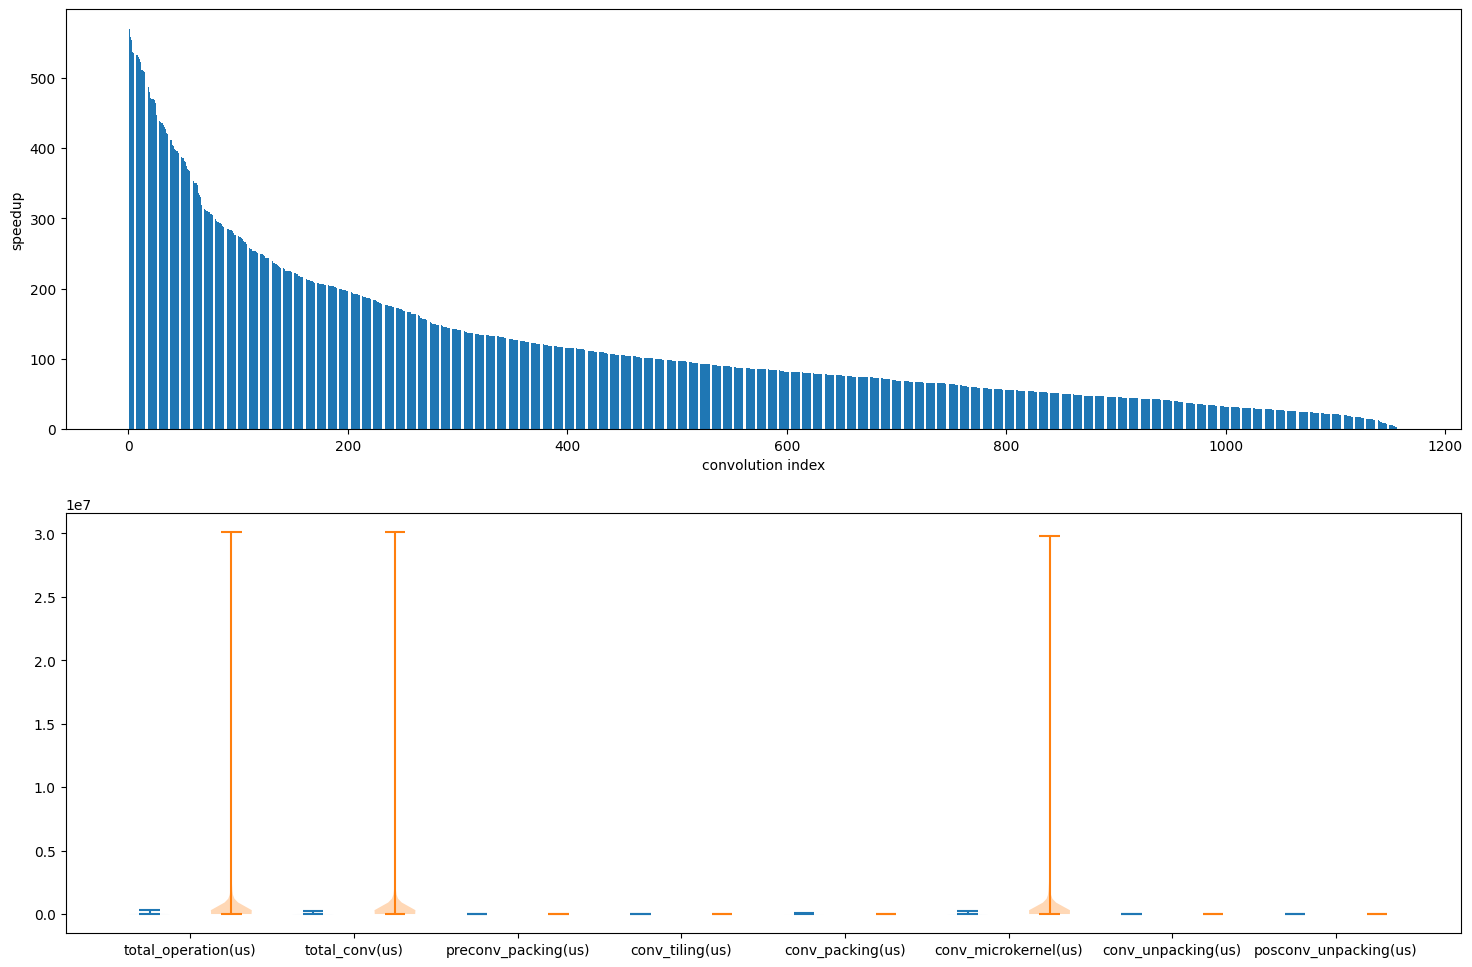

In [24]:
if (proced.value == "Speedup Assessment") and (not direct.empty) and (not baseline.empty):
    distribution = (baseline["total_operation(us)"]/direct["total_operation(us)"]).sort_values(ascending=False)
    distribution = distribution - 1

    plt.figure(figsize=(18, 12))

    #speed distribution plot
    plt.subplot(2, 1, 1)

    plt.bar(range(1, distribution.shape[0]+1, 1), distribution)

    plt.ylabel("speedup")
    plt.xlabel("convolution index")
    #plt.xticks(range(1, distribution.shape[0]+1, 1), distribution.index)

    #violin plots
    plt.subplot(2, 1, 2)

    plt.violinplot(direct.iloc[:, ::2], positions=[1, 3, 5, 7, 9, 11, 13, 15])
    plt.violinplot(baseline.iloc[:, ::2], positions=[2, 4, 6, 8, 10, 12, 14, 16])

    plt.xticks([1.5, 3.5, 5.5, 7.5, 9.5, 11.5, 13.5, 15.5], baseline.columns[::2])

    plt.show()
else:
    warnings.warn('Only "Speedup Assessment" procediment generates plots')